In [1]:
import pandas as pd
# ============================================================
# Notebook setup: run this before everything
# ============================================================
# -- Copied from lecture
%load_ext autoreload
%config IPCompleter.greedy=True
%autoreload 1
%aimport util
import logging

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report

from util import util

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

# Load datasets
X_train, y_train = util.load_dataset_xy('7_gecco2019_train_water_quality.csv')
X_val, y_val = util.load_dataset_xy('8_gecco2019_valid_water_quality.csv')
X_test, y_test = util.load_dataset_xy('6_gecco2019_test_water_quality.csv')

# Get feature columns
features = util.get_feature_columns(X_train)

# Random Forest Classifier
The Random Forest Classifier is a popular ensemble learning method that combines multiple decision trees to improve the predictive performance of the model. It works by creating a collection of decision trees, each of which is trained on a random subset of the training data. The final prediction is made by aggregating the predictions of all the trees.

As random forests rely on many simple learners which themselves decide on decision boundaries, they are less affected by datasets with a large class imbalance. This is quite useful in our case as out dataset contains mainly uncontaminated samples.

Another advantage of decision boundaries is that they do not require us to standardize the data. This greatly increases the explainability of the model.

## Training the Random Forest
As with other Keras models, training a random forest is quite straightforward. We simply instantiate the model and fit it to the training data. We will mainly rely on the default parameters, but set the number of estimators to 100. Usually, we would do a grid search to find the best number of estimators, but 100 is a good starting point.

In [2]:
# Create a RandomForestClassifier with default
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Evaluation on the Training Data
Next, we evaluate the model on the training data.

In [3]:
# Predict probabilities on the training set
y_pred_train = rf.predict(X_train)

# Print performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Confusion Matrix:
 [[132268      0]
 [     0    212]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00    132268
        True       1.00      1.00      1.00       212

    accuracy                           1.00    132480
   macro avg       1.00      1.00      1.00    132480
weighted avg       1.00      1.00      1.00    132480



The classification results on the training data show perfect scores for both classes, with all samples correctly classified. This indicates that the model has learned the training data extremely well, as evidenced by the confusion matrix where no misclassifications occur. However, since the data is highly imbalanced, these results might not reflect the model's ability to generalize to unseen data. In imbalanced settings, perfect performance on the training set can sometimes be misleading, as the model might simply be memorizing patterns specific to the training distribution rather than capturing robust, generalizable relationships. It is therefore important to evaluate the model's performance on unseen data.

## Evaluation on the Test Data
The actual performance of the model becomes visible, when evaluating it on the test data. This shows whether the model just memorized the training data or if it is able to generalize to new, unseen patterns.

In [4]:
# Predict probabilities on the test set
y_pred_test = rf.predict(X_test)

# Print performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

Confusion Matrix:
 [[31455     4]
 [   98    93]]
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     31459
        True       0.96      0.49      0.65       191

    accuracy                           1.00     31650
   macro avg       0.98      0.74      0.82     31650
weighted avg       1.00      1.00      1.00     31650



The test results reveal a notable divergence from the perfect scores observed on the training data, especially for the minority "True" class. While the model continues to perform flawlessly for the majority "False" class on the test set, its performance for the "True" class drops significantly. This indicates that, although the model can accurately identify most negatives, it misses over half of the positive cases in unseen data. Still, from all the models we have tested so far, the results of the random forest are the best.

## Feature Importances
The final hidden superpower of random forests is that the training automatically yields feature importances. Random forests are ensembles of decision trees that make splits based on reducing impurity (like Gini impurity). Each time a feature is used to split the data, it contributes to lowering the impurity. The algorithm aggregates these reductions across all trees, resulting in a measure of each feature's importance in predicting the target.

This means, that after training, we can easily get additional insights into our dataset, basically for free.

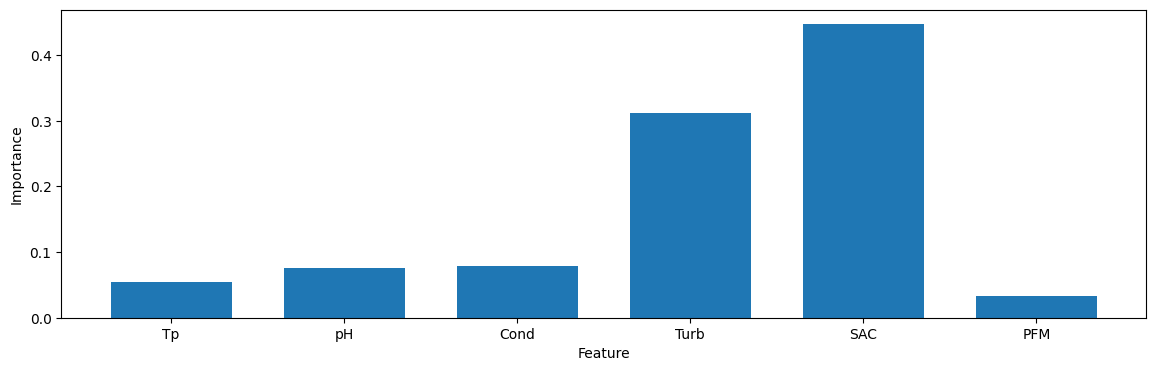

In [5]:
feature_importances = pd.Series(index=features, data=rf.feature_importances_)
util.plot_bars(feature_importances, figsize=figsize, xlabel='Feature', ylabel='Importance')

## Permutation Importances
We can also compute the permutation importances, which measures the effect of shuffling the values of a feature on the model's performance. This is useful for understanding how the model's performance varies across different feature orders.

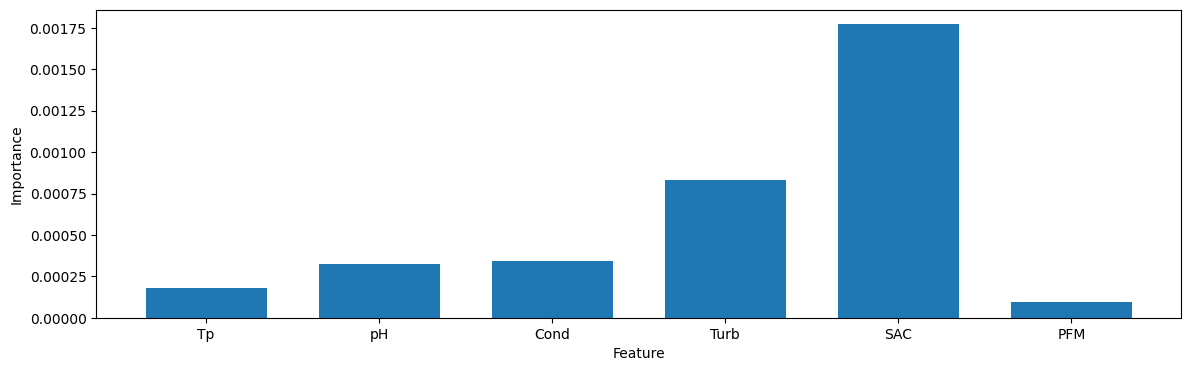

In [6]:
# Compute permutation importances on the training data
r_train = permutation_importance(rf, X_train, y_train, n_repeats=30, random_state=0)
permutation_importances_train = pd.Series(index=features, data=r_train.importances_mean)
util.plot_bars(permutation_importances_train, figsize=figsize, xlabel='Feature', ylabel='Importance')

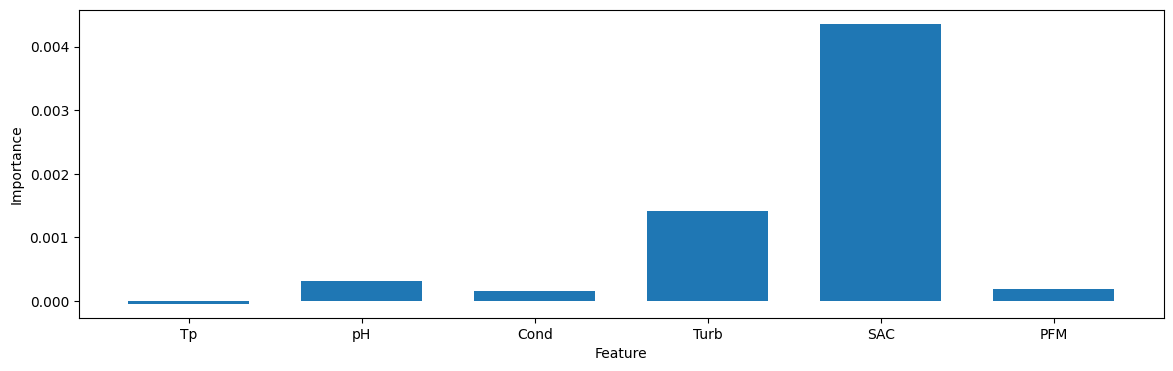

In [7]:
# Compute permutation importances on the test data
r_test = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=0)
permutation_importances_test = pd.Series(index=features, data=r_test.importances_mean)
util.plot_bars(permutation_importances_test, figsize=figsize, xlabel='Feature', ylabel='Importance')

While both `SAC` and `Turb` remain the most important features, regardless of the approach, in the test set the importance of `pH` and `Cond` swaps. All in all, this analysis matches with our observations made with different models, e.g., with the autoencoder which showed the biggest reconstruction errors for `SAC` and `Turb`.